In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

%matplotlib inline

bif_c = 0.1
num_iter_max=200000
# alpha=0.2
alpha=0.3
# alpha=0.5
# alpha=0.8 # predict diverge
# vae_lr=1e-5
vae_lr=5e-4
ratio_lr=5e-4
ratio_early=100
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_pendulum_B_"

loss_list = []
normalized_loss_list = []

In [2]:
import gym
import custom_gym
env = gym.make(env_name)

seed = 0
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = 1
print(s_dim, a_dim, z_dim)



c = 0.21455680991172585
2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae_")


offline_data = pickle.load(open("offline_data.pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info.pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae_


In [4]:
args_init_dict = {"offline_data": offline_data,
             "s_dim": s_dim,
             "a_dim": a_dim,
             "z_dim": z_dim,
#              "policy":agent.select_action,
             "mdp_policy":None,
             "bamdp_policy":agent.policy.my_np_select_action,
                  "debug_info":debug_info,
                  "env" : env}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load()
iwvi.update_mulogvar_offlinedata()

load vi_iw_ckpt_basepart
success load vi_iw_ckpt_basepart


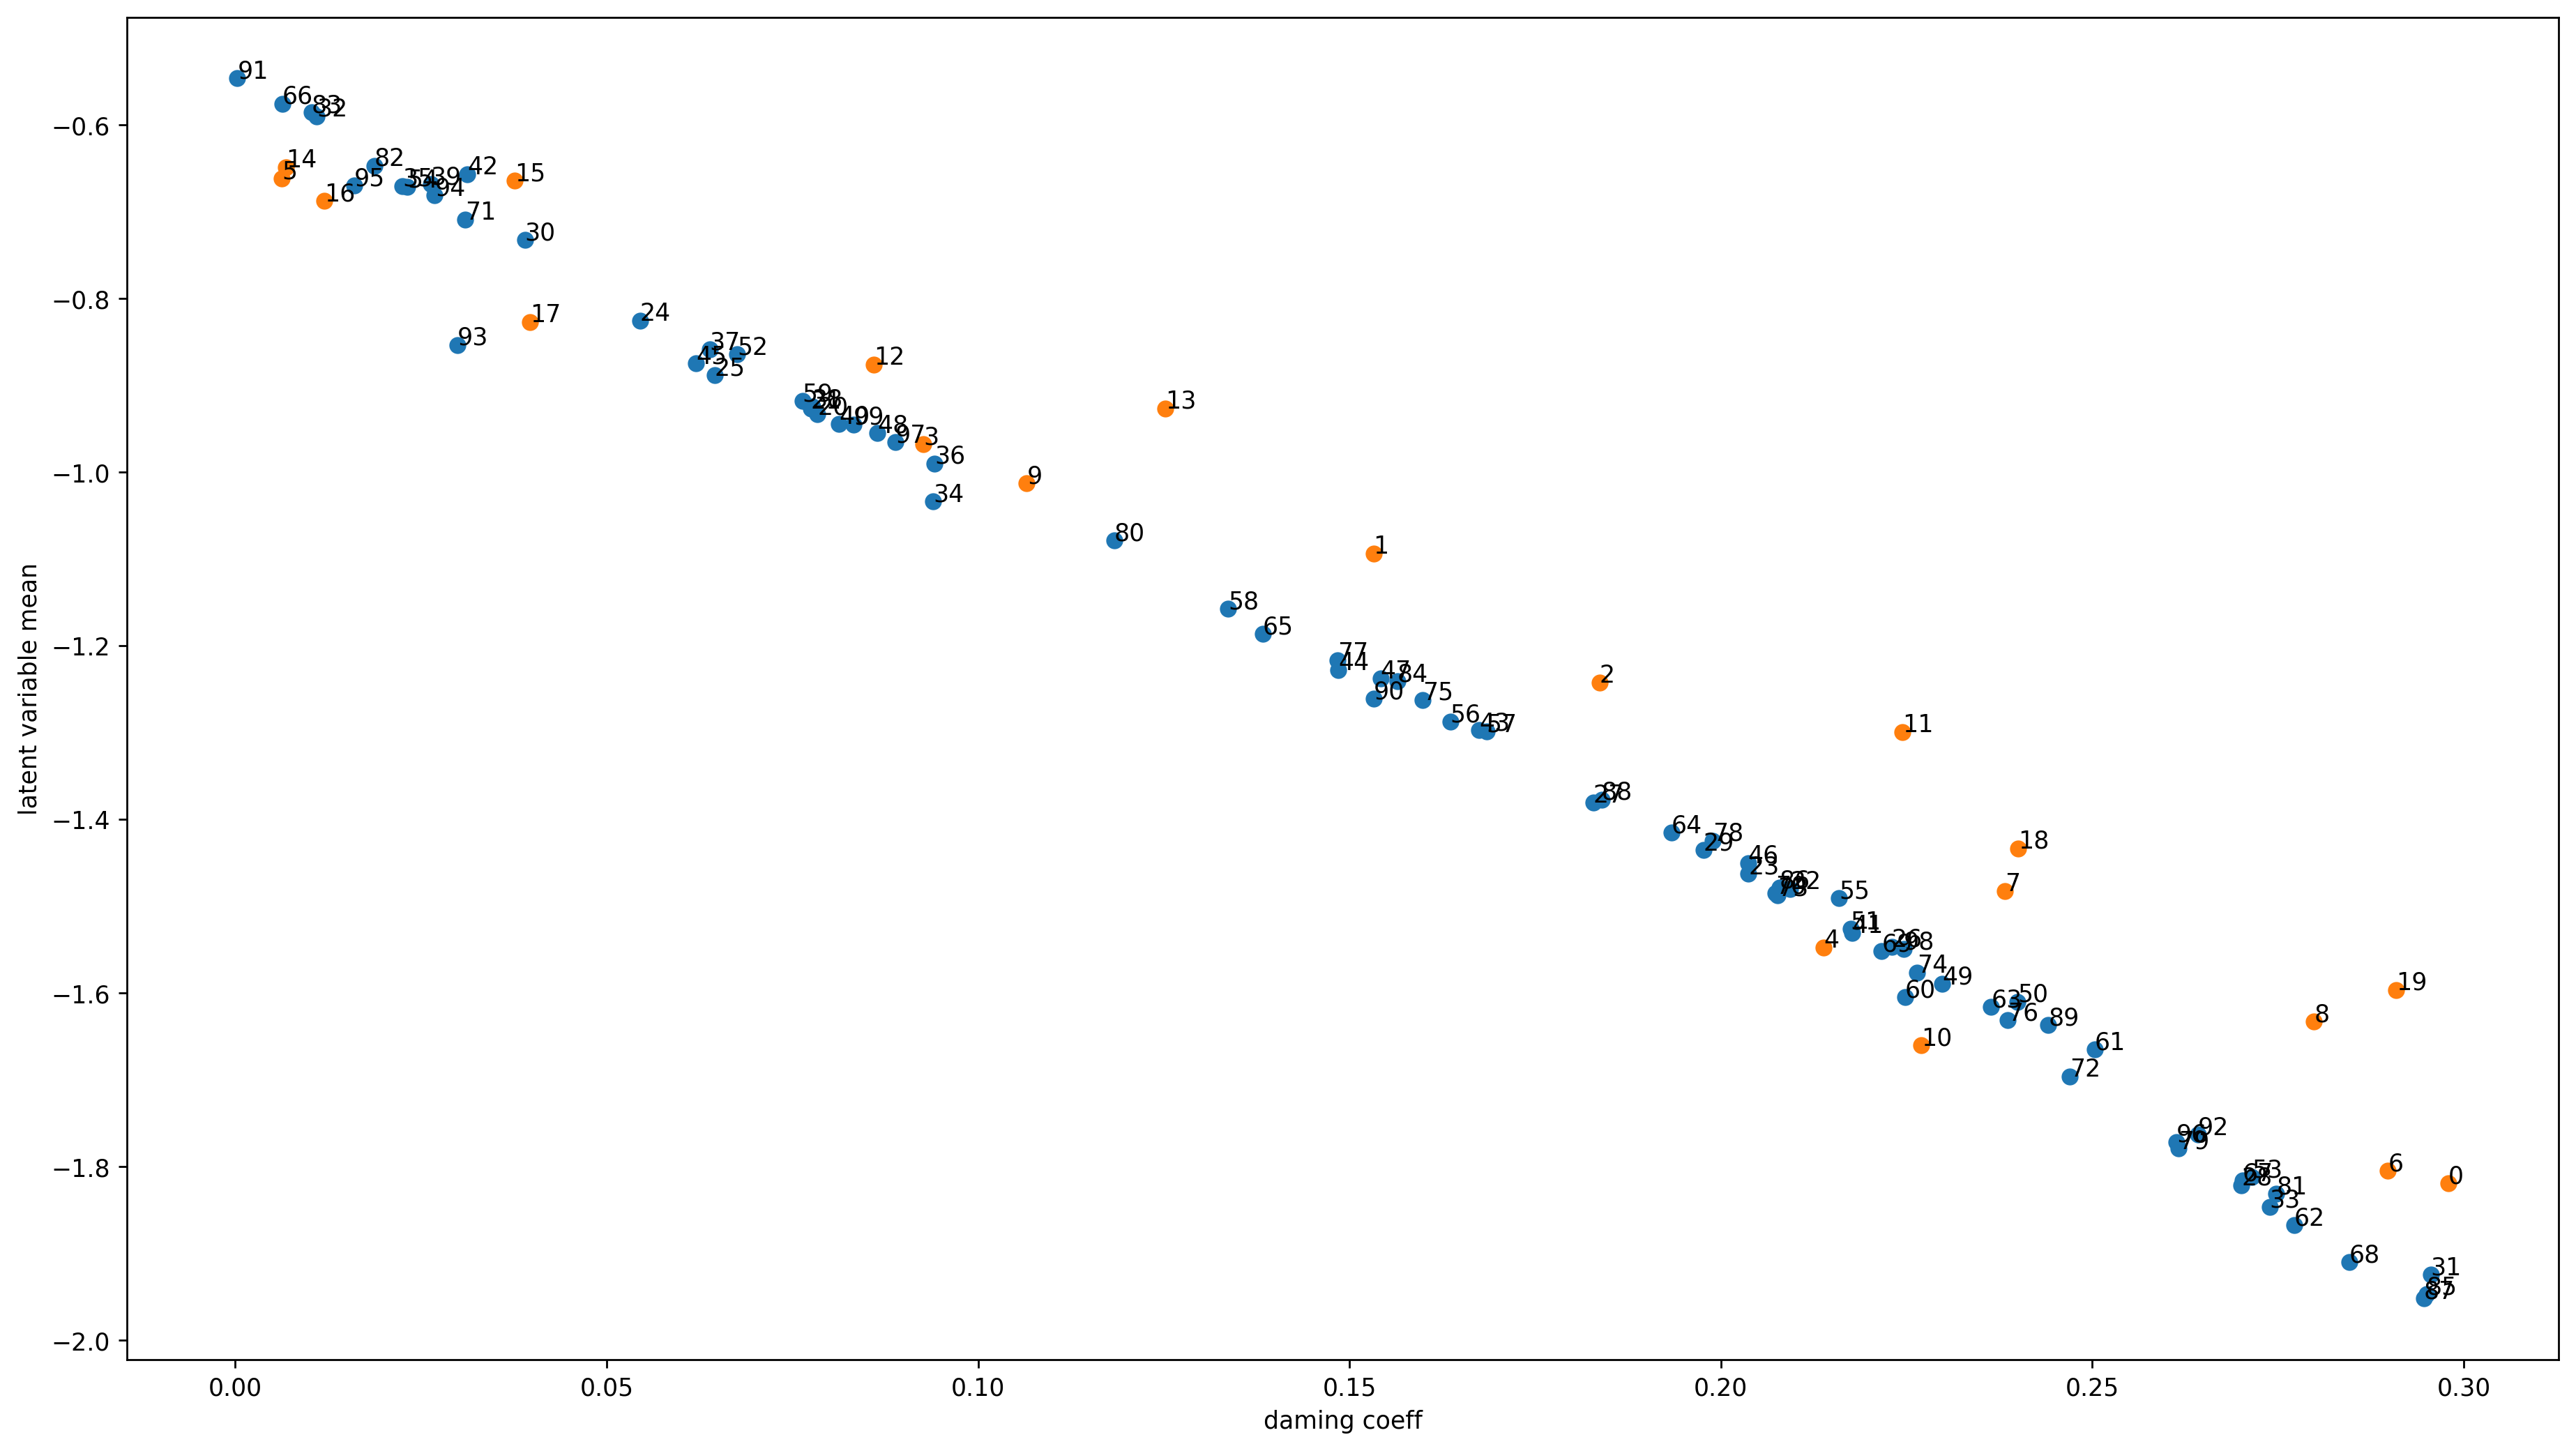

[0.29791016 0.15322083 0.18365987 0.09261918 0.21384459 0.00627838
 0.28977922 0.23826577 0.27982297 0.10656002]
[0.22693388 0.2244697  0.08596681 0.12522523 0.00685178 0.03757813
 0.01196297 0.03966669 0.24002473 0.29092061]
[0.07835583 0.07746172 0.20934208 0.20371297 0.05450337 0.06451795
 0.2229776  0.1828022  0.27007945 0.19762321]
[0.03898917 0.29555121 0.01093391 0.27386888 0.09397505 0.02248499
 0.09414549 0.06385285 0.07767223 0.02632497]
[0.08125716 0.21770374 0.03126921 0.1674378  0.14847363 0.06205282
 0.20363688 0.15417275 0.08645989 0.22978046]
[0.23991758 0.21743357 0.06757306 0.2714981  0.02319353 0.21589278
 0.16356097 0.16844176 0.13367955 0.07634676]
[0.22476822 0.25029279 0.2771417  0.23638723 0.19333075 0.13834196
 0.00632632 0.27019082 0.28455401 0.22163373]
[0.20737241 0.03096922 0.24692379 0.20760993 0.22644138 0.1598574
 0.23863549 0.1484238  0.19891706 0.26157098]
[0.11830818 0.27478066 0.01872246 0.01027625 0.15642099 0.29498274
 0.20786144 0.29459763 0.18393

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_iter0.eps")
plt.savefig(figfilenamehead+"damping_latent_iter0.pdf")
plt.show()

# plt.figure(figsize=(16,12))
# plt.xlim([0.06,0.14])
# plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
# plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.plot([bif_c, bif_c],[np_mulogvar[:,0].min(),np_mulogvar[:,0].max()])
# for i in range(len(debug_info)):
#     plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 1.1920928955078125e-06
c = 0.16346495489906906


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 2.986060619354248
c = 0.175923049855898

 2 2.793731451034546
c = 0.213101048692264

 3 2.878207206726074
c = 0.14501806056071762

 4 2.757437229156494
c = 0.004052611988015664

 5 2.6919469833374023
c = 0.120134560420777

 6 2.617983102798462
c = 0.25697024030079035

 7 2.6232011318206787
c = 0.09642657758269942

 8 2.8965861797332764
c = 0.05526129195564814

 9 2.8760385513305664
c = 0.11417486037608537

 10 3.074878454208374
c = 0.25864988011260814

 11 2.7580220699310303
c = 0.020876132555705383

 12 2.8644864559173584
c = 0.2613891486606151

 13 3.04201602935791
c = 0.10624180953664825

 14 2.7991082668304443
c = 0.03203027777652895

 15 2.9639506340026855
c = 0.1622476552961531

 16 2.5620031356811523
c = 0.1618277342655034

 17 2.544286012649536
c = 0.055320312028603325

 18 2.5797793865203857
c = 0.09391364165595244

 19 2.7079787254333496
c = 0.11885913261799258

 20 2.617009401321411
c = 0.11403897859981632

 21 2.484619617462158
c = 0.09912067121474619

 22 2.61528134346

In [7]:
# fig = plt.figure(figsize=(18,10))
# ax_list = []
# for i in range(50):
#     ax_list.append(fig.add_subplot(5, 10, i+1))
#     ax_list[-1].set_xticks([])
#     ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1]) 
#     ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1]) 
# print("オフラインデータvs実環境方策rollout")


 0 1.1920928955078125e-06
c = 0.20021770810986864

 1 3.04992938041687
c = 0.1983582812192558

 2 2.5848145484924316
c = 0.022555950291700478

 3 2.6250104904174805
c = 0.20541677419620874

 4 2.5595970153808594
c = 0.10100278390403257

 5 2.5927350521087646
c = 0.18626578567738697

 6 2.7233939170837402
c = 0.05051976271514567

 7 2.9957330226898193
c = 0.047219332290270255

 8 2.4974348545074463
c = 0.1703964189334006

 9 2.610459089279175
c = 0.14840815680292022

 10 2.6000778675079346
c = 0.24494872822400177

 11 2.743614435195923
c = 0.025342155733352467

 12 2.7302987575531006
c = 0.29120495159551035

 13 2.7410738468170166
c = 0.1062823595846313

 14 2.832547426223755
c = 0.2005682341251094

 15 2.8068370819091797
c = 0.2575002131665844

 16 2.739445924758911
c = 0.2478069086585581

 17 2.7967092990875244
c = 0.10556652164894924

 18 2.7395129203796387
c = 0.1263102409001565

 19 2.6936442852020264
c = 0.06421935796424785

 20 2.88954496383667
c = 0.162199131307732

 21 2.72045


 74 3.160360336303711
c = 0.1922179819204177

 75 3.0666141510009766
c = 0.19400590626826322

 76 2.6450390815734863
c = 0.2672795379972454

 77 2.872300148010254
c = 0.029065835958021

 78 2.9805030822753906
c = 0.2245722921775796

 79 2.784311294555664
c = 0.1051746907010319

 80 3.01753568649292
c = 0.13874576836122632

 81 2.6061511039733887
c = 0.29309690014830886

 82 2.5360751152038574
c = 0.07047958108149714

 83 2.5227739810943604
c = 0.08601192491679845

 84 2.6935043334960938
c = 0.06872835951049482

 85 2.6311824321746826
c = 0.11532561558742395

 86 2.7992827892303467
c = 0.04002030948199862

 87 2.556114435195923
c = 0.24862906093642148

 88 2.7626569271087646
c = 0.017403030470802182

 89 2.866421937942505
c = 0.16351090672440727

 90 2.558800458908081
c = 0.08953965430239402

 91 2.641657590866089
c = 0.0517091874600617

 92 2.7161378860473633
c = 0.18516421320066853

 93 2.687648296356201
c = 0.19422658353964023

 94 2.5522568225860596
c = 0.06961774284821265

 95 2.5

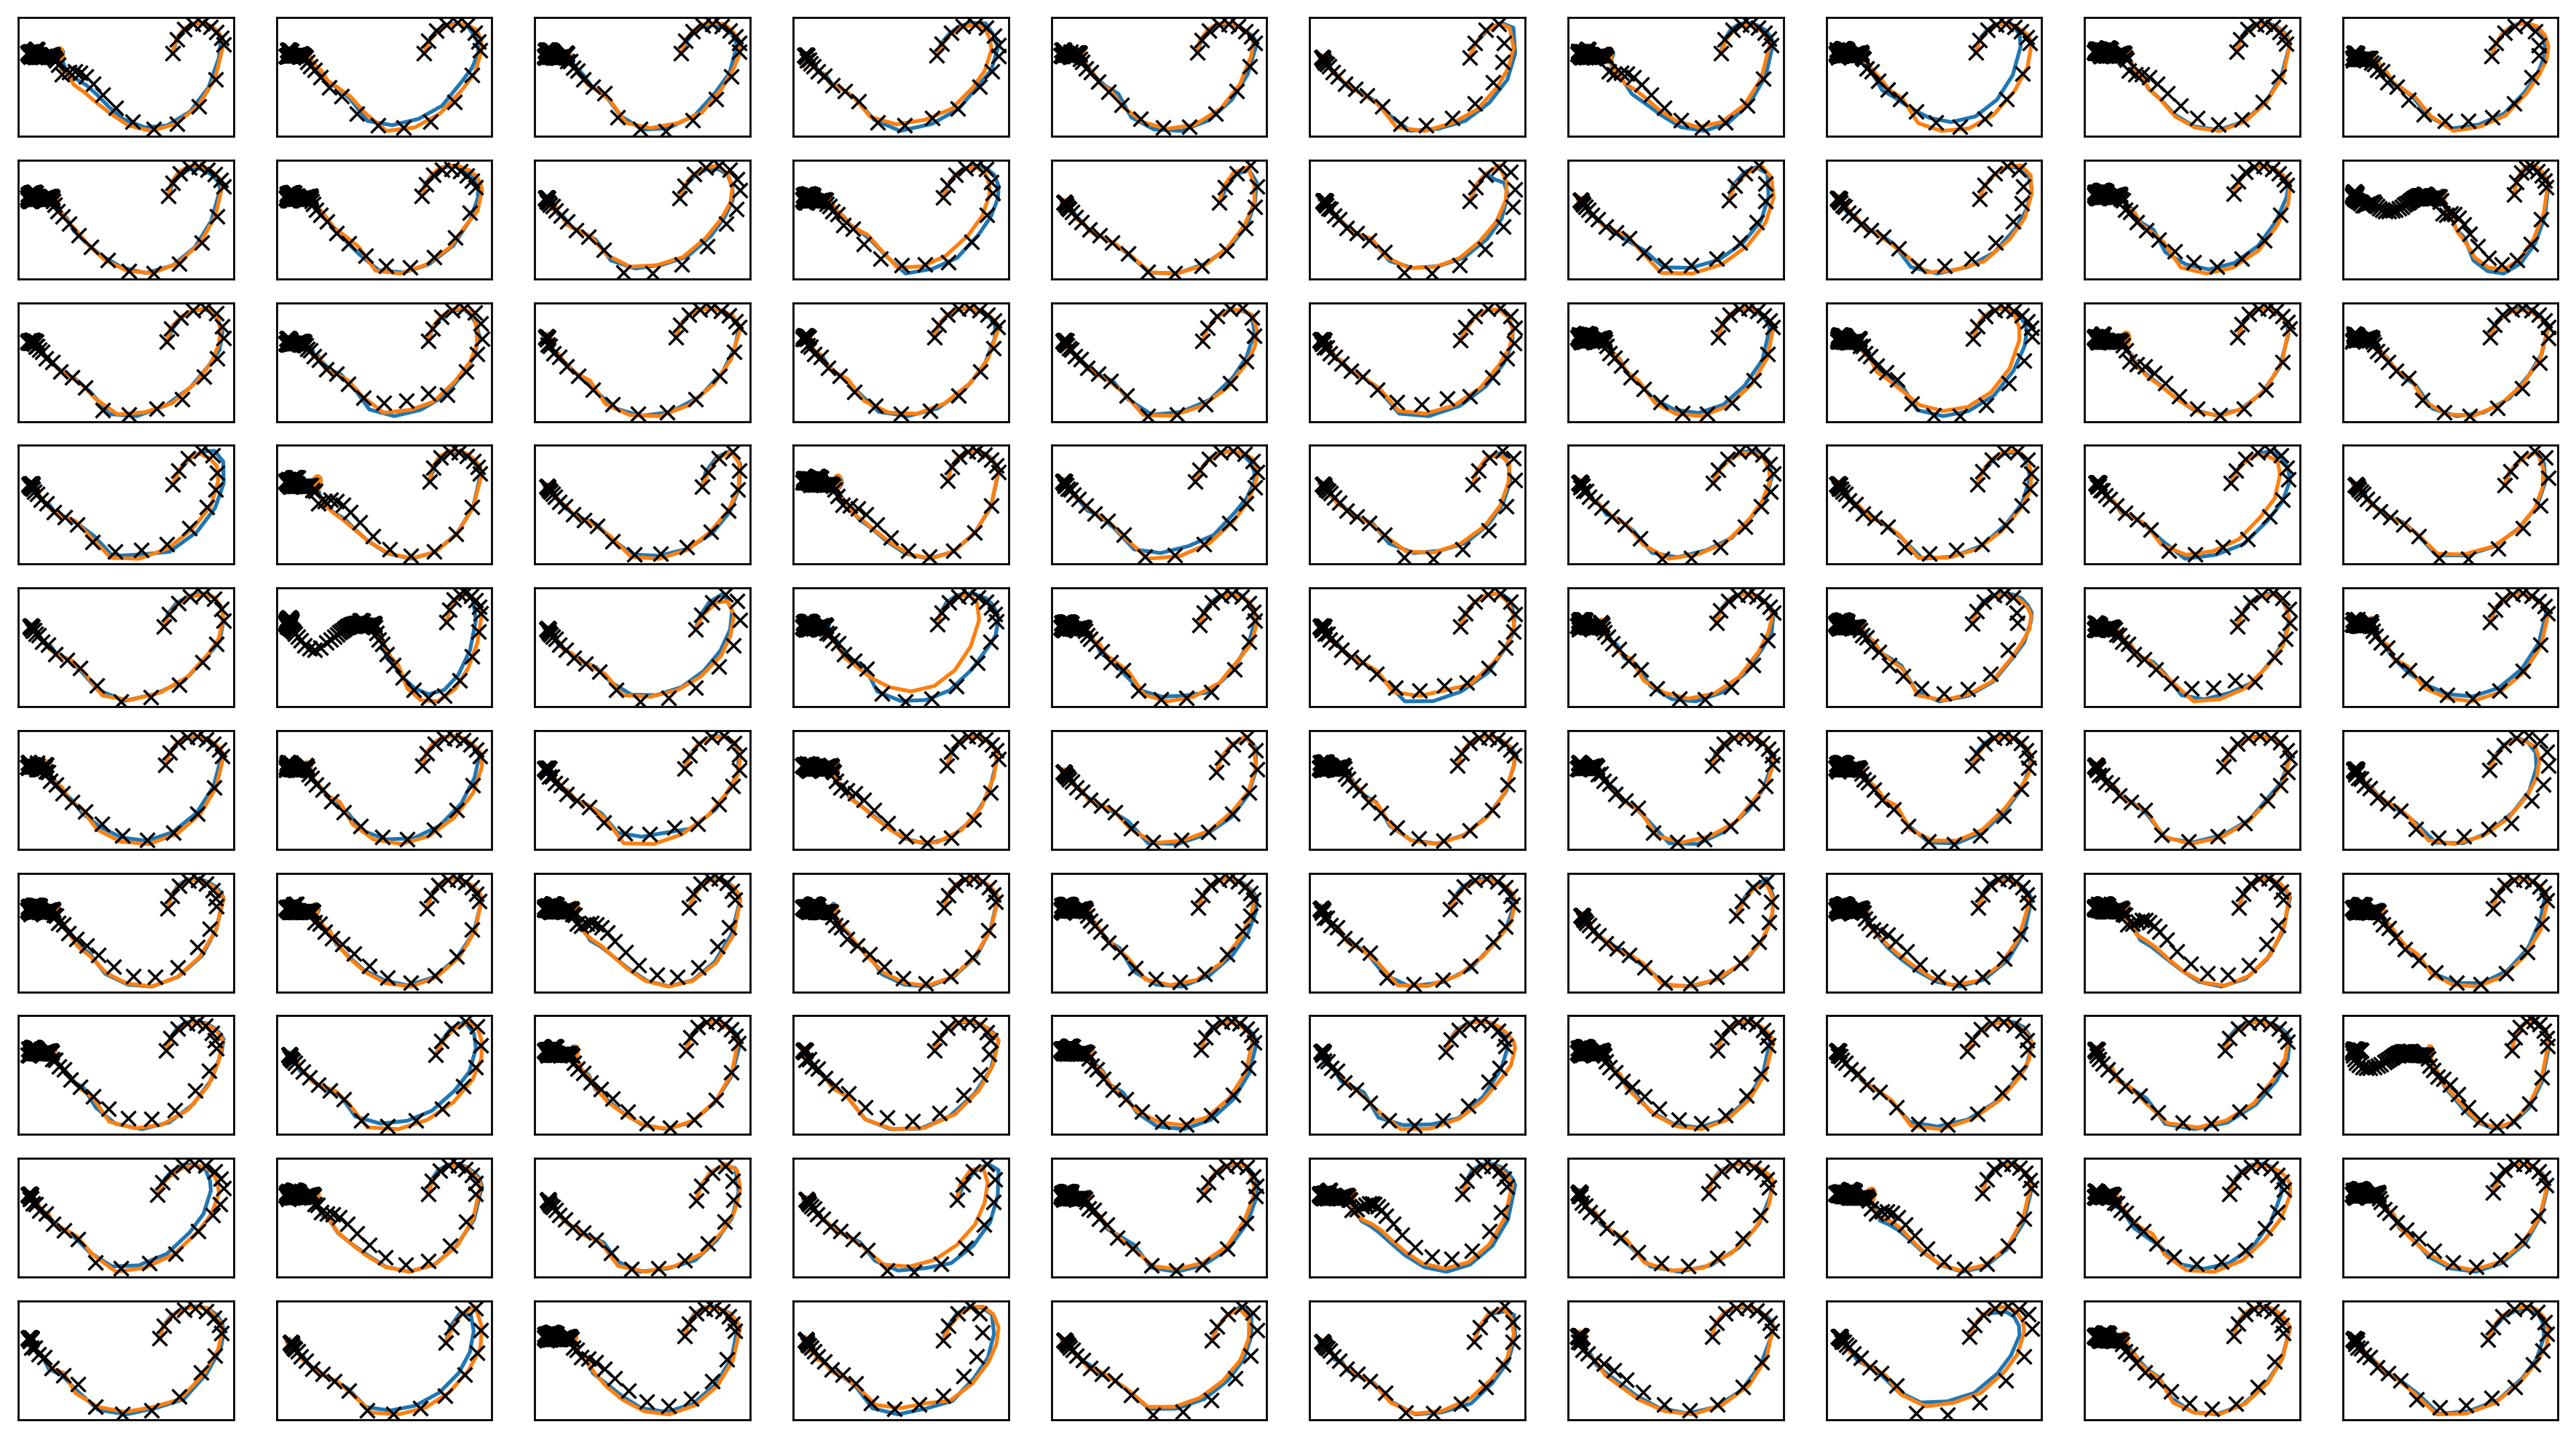

In [8]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
plt.savefig(figfilenamehead+"iter0.png")
plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [9]:
print(datetime.datetime.now())

2023-03-30 03:52:51.322620


# Iter 1